In [139]:
#_init_.py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

def run_ecolab(env,agents,Niterations=1000,earlystop=True):
    """
    Run ecolab, this applies the rules to the agents and the environment. It records
    the grass array and the locations (and type) of agents in a list it returns.
    
    Arguments:
    - env = an Environment object
    - agents = a list of agents (all inherited from Agent)
    - Niterations = number of iterations to run (default = 1000)
    - earlystop = if true (default), will stop the simulation early if no agents left.
    """
    
    counts_cows =[]
    record = []
    infected_cows = []
    infected_record = []
    for it in range(Niterations):
        # choose cows will be infeected randomly every year
        if it % 365 == 0:
            for agent in agents:
                if len(infected_cows) == 7:    # could change the number to a ratio
                    break
                else:
                    check_infected = agent.infected_virus()
                if check_infected == True:
                    infected_cows.append(agent)
                    agent.inf_index = 3
                    agents.remove(agent)
        # recover            
        if it % 90 == 0:
            for agent in infected_cows:
                check_recover = agent.recover()
                if check_recover == False:
                    infected_cows.remove(agent)
                    agent.inf_index =0 
                    agents.append(agent)
                else:
                    agent.age = agent.maxage+1
                        
        #if (it+1)%100==0: print("%5d" % (it+1), end="\r") #progress message
        area = []
        for agent in infected_cows:
            agent.move(env)
            agent.eat(env,agents)
            area = agent.infected_area(area)
            a = agent.breed()
            if a is not None: agents.append(a)       
                
                
        #for each agent, apply rules (move, eat, breed)
        for agent in agents:
            agent.move(env)
            if list(agent.position) in area:
                agent.inf_index +=1
            if agent.inf_index == 2:
                #agent.inf_index = 0 
                infected_cows.append(agent)
                agents.remove(agent)
            agent.eat(env,agents)
            a = agent.breed()
            if a is not None: agents.append(a)


                
        #removed dead agents
        agents = [a for a in agents if not a.die()]
        
        #infected cows infect rulesf
        
        
        #grow more grass
        env.grow()

        #record the grass and agent locations (and types) for later plotting & analysis
        counts_cows.append(len(agents))
        infected_record.append(len(infected_cows))
        record.append({'grass':env.grass.copy(),'agents':np.array([a.summary_vector() for a in agents])})
        #infected_record.append({'infected_agents':np.array([b.summary_vector() for b in infected_cows])})
        print(type(infected_record),type(record))
        
        #stop early if we run out of rabbits and foxes
        if earlystop:
            if len(agents)==0: break
                
    return record,counts_cows,infected_record

def draw_animation(fig,record,fps=20,saveto=None):
    """
    Draw the animation for the content of record. This doesn't use the draw
    functions of the classes.
    - fig figure to draw to
    - record = the data to draw
    - fps = frames per second
    - saveto = where to save it to
    """
    #rc('animation', html='html5')
    if len(record)==0: return None

    im = plt.imshow(np.zeros_like(record[0]['grass']), interpolation='none', aspect='auto', vmin=0, vmax=3, cmap='Greens')
    ax = plt.gca()

    rabbitsplot = ax.plot(np.zeros(1),np.zeros(1),'r+',markersize=10,mew=3)
    infec_rabbitsplot = ax.plot(np.zeros(1),np.zeros(1),'b+',markersize=10,mew=3)

    def animate_func(i):
            im.set_array(record[i]['grass'])
            ags = record[i]['agents']
            if len(ags)==0:
                rabbitsplot[0].set_data([],[])
                return
            coords = ags[ags[:,-1].astype(bool),0:2]
            rabbitsplot[0].set_data(coords[:,1],coords[:,0])
            #return [im]#,rabbits,foxes]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = len(record),
                                   interval = 1000 / fps, repeat=False # in ms
                                   )
    if saveto is not None: anim.save(saveto, fps=fps, extra_args=['-vcodec', 'libx264']) 
    from IPython.display import HTML
    return HTML(anim.to_jshtml())

### problem
def get_agent_counts(record):
    """
    Returns the number of foxes, rabbits and amount of grass in a N x 3 numpy array
    the three columns are (Foxes, Rabbits, Grass).
    """
    counts = []
    for r in record:
        ags = r[0]['agents']
        print(ags[:,-1])
        if len(ags)==0:
            nF = 0
            nR = 0
        else:
            nF = np.sum(ags[:,-1]==0)
            nR = np.sum(ags[:,-1]==1)
        nG = np.sum(r[0]['grass'])
        counts.append([nF,nR,nG])
    counts = np.array(counts)
    print(counts,nF,nR,nG)
    return counts

In [140]:
#agents.py
import random
import numpy as np
import matplotlib.pyplot as plt

#Helper functions to calculate distances
def calcdistsqr(v):
    """Get euclidean distance^2 of v"""
    return np.sum(v**2)

def calcdist(v):
    """Get euclidean distance of v"""
    return np.sqrt(np.sum(v**2))


class Agent:
    """
    Base class for all types of agent
    """
    def __init__(self,position,age,speed,lastbreed,female,infected,inf_index):
        """
        age = age of agent in iterations
        food = how much food the agent has 'inside' (0=empty, 1=full)
        position = x,y position of the agent
        speed = how fast it can move (tiles/iteration)
        lastbreed = how long ago it last reproduced (iterations)
        """
        self.age = age
        self.position = position
        self.speed = speed
        self.lastbreed = lastbreed
        self.female = female
        self.infected = infected    #check infected or not
        self.inf_index = inf_index  #check how many time cow contact infected cows

    def breed(self):
        """
        This will either return None, or a new agent object
        """
        new_agent = None
        if (self.lastbreed>self.breedfreq) and self.female:
            self.lastbreed = -1
            new_agent = type(self)(self.position,0,self.speed,10, bool(random.getrandbits(1)),0,0)

        self.age+=1
        self.lastbreed+=1
        return new_agent
       
    def move(self,env):
        pass #to implement by child class
    
    def trymove(self,newposition,env):
        if env.check_position(newposition):
            self.position = newposition
        #ensures it's in the environment and rounds to nearest cell
        #env.fix_position(self.position)
    
    def eat(self,env,agents):
        pass #to implement by child class
    
    def summary_vector(self):
        """
        Returns a list of the location (x,y) and a 0=fox, 1=rabbit, e.g.
        [3,4,1] means a rabbit at (3,4).
        """
        return [self.position[0],self.position[1],type(self)==Rabbit]
    
class Rabbit(Agent):
    
    breedfreq = 1698 #how many iterations have to elapse between reproduction events
    maxage = 13140 #how long do they live
    
    def __init__(self,position,age=None,speed=1,lastbreed=0, female=bool(random.getrandbits(1)),infected =False,inf_index=0 ):
        """
        A Rabbit agent. Arguments:
        age = age of agent in iterations (default is a random value between 0 and maxage)
        food = how much food the agent has 'inside' (0=empty, 1=full), default = 10
        position = x,y position of the agent (required)
        speed = how fast it can move (tiles/iteration) (default=1)
        lastbreed = how long ago it last reproduced (iterations) (default=0)
        """
        if age is None: age = np.random.randint(self.maxage)
        super().__init__(position=position,age=age,speed=speed,
                         lastbreed=lastbreed,female=female,infected=infected,inf_index=inf_index)
        self.eaten = False
        
    def move(self,env):
        """
        cow movement:
          - Moves in random direction
        """
        #no food in range, pick a random direction...
        d = np.random.rand()*2*np.pi #pick a random direction
        delta = np.round(np.array([np.cos(d),np.sin(d)])* self.speed)
        self.trymove(self.position + delta,env)
                        
    def infected_virus(self):
        prob = np.random.randint(10)
        if prob % 10 <= 1:    # 20% infection rate
            self.infected = True    
        return self.infected

    def recover(self):
        prob = np.random.randint(10)
        if prob % 10 < 8 :  # 80% recover rate
            self.infected = False
        return self.infected
    
    def infected_area(self,area):
        area.append([self.position[0]-1,self.position[1]+1])
        area.append([self.position[0],self.position[1]])
        area.append([self.position[0],self.position[1]+1])
        area.append([self.position[0]+1,self.position[1]+1])
        area.append([self.position[0]+1,self.position[1]])
        area.append([self.position[0]+1,self.position[1]-1])
        area.append([self.position[0],self.position[1]-1])
        area.append([self.position[0]-1,self.position[1]-1])
        area.append([self.position[0]-1,self.position[1]])
        return(area)
        
    def die(self):
        """
        Returns true if it needs to expire, either due to:
         - no food left
         - old age
         - being eaten
        """
        if self.age>self.maxage: return True
        return False
        


In [141]:
#environments.py

import numpy as np
import matplotlib.pyplot as plt

#helper function
def argmax_2darray(a):
    """
    Returns the maximum location in a n-d array
    """
    return np.unravel_index(a.argmax(), a.shape)

class Environment:
    def __init__(self,shape=[40,40],startgrass=1,maxgrass=3,growrate=10):
        """
        Create the environment
        Parameters:
         - shape = shape of the environment
         - startgrass = initial amount of grass
         - maxgrass = maximum amount of grass allowed in each tile
         - growrate = number of tiles which get extra grass each iteration
        """
        self.maxgrass = maxgrass #maximum it can grow to
        self.growrate = growrate #how many new items of food added per step
        self.shape = shape #shape of the environment
        self.grass = np.full(self.shape,startgrass) #2*np.trunc(np.random.rand(*self.shape)*2)+2 #initial grass
        
        
    def get_food(self,position):
        """
        Returns the amount of food at position
        """
        return self.grass[int(position[0]),int(position[1])]
    
    def reduce_food(self,position,amount=1):
        """
        Reduce the amount of food at position by amount
        (note, doesn't check this doesn't go negative)
        """
        self.grass[int(position[0]),int(position[1])]-=amount
    
    def get_loc_of_grass(self,position,vision):
        """
        This finds the location of the cell with the maximum amount of food near 'pos',
        within a circle of 'vision' size.
        For example env.get_dir_of_food(np.array([3,3]),2)
        if two or more cells have the same food then it will select between them randomly.
        """
        
        #we temporarily build a new datastructure to look for the largest grass in with a
        #strip/boundary around the edge of zero food. This feels like the simplest code
        #to solve the edge case problem, but is quite a slow solution.
        boundary = 10
        pos = position + boundary
        grasswithboundary = np.zeros(np.array(self.grass.shape)+boundary*2)
        grasswithboundary[boundary:-boundary,boundary:-boundary] = self.grass
        #we search just a circle within 'vision' tiles of 'pos' (these two commands build that search square)
        searchsquare = grasswithboundary[int(pos[0]-vision):int(pos[0]+vision+1),int(pos[1]-vision):int(pos[1]+vision+1)]
        searchsquare[(np.arange(-vision,vision+1)[:,None]**2 + np.arange(-vision,vision+1)[None,:]**2)>vision**2]=-1
        #this returns the location of that maximum food (with randomness added to equally weight same-food cells)         
        if np.all(searchsquare<=0): return None #no food found
        return argmax_2darray(searchsquare+0.01*np.random.rand(vision*2+1,vision*2+1))+position-vision
        

    def check_position(self,position):
        """
        Returns whether the position is within the environment
        """
        position[:] = np.round(position)
        if position[0]<0: return False
        if position[1]<0: return False
        if position[0]>self.shape[0]-1: return False
        if position[1]>self.shape[1]-1: return False
        
        #this adds a 'wall' across the environment...
        #if (position[1]>5) and (position[0]>self.shape[0]/2-3) and (position[0]<self.shape[0]/2+3): return False
        return True
            
    def get_random_location(self):
        """
        Returns a random location in the environment.
        """
        return np.random.randint([0,0],self.shape)
        
        #if we have a more complicated environment shape, use this instead to place new grass in valid location...
        #p = np.array([-10,-10])
        #while not self.check_position(p):
        #    p = np.random.randint([0,0],self.shape)
        #return p
    
    def grow(self):
        """
        Adds more grass (random locations) 
         - amount added controlled by self.growrate
        """
        for it in range(self.growrate):
            loc = self.get_random_location()
            if self.grass[loc[0],loc[1]]<self.maxgrass:
                self.grass[loc[0],loc[1]]+=1

In [142]:
import random
#create default environment
env = Environment(shape=[100,140],growrate=0,maxgrass=2,startgrass=1)
    
#create agents (rabbits and foxes)
Nrabbits = 70
agents = [] 
for i in range(Nrabbits):
    r = Rabbit(position=env.get_random_location(),speed=1, lastbreed=random.randint(0,1638), female = bool(random.getrandbits(1)),infected = 0)
    agents.append(r)

In [143]:
#run the simulation (default = 1000 iterations)
record,cc,inf_c = run_ecolab(env,agents)

In [144]:
#record = record[:1]

In [145]:
#need to use %matplotlib notebook
# %matplotlib notebook 
# fig = plt.figure( figsize=(8,8) )
# draw_animation(fig,record[::1],5,saveto='test_anim.mp4') #draw every 5th frame

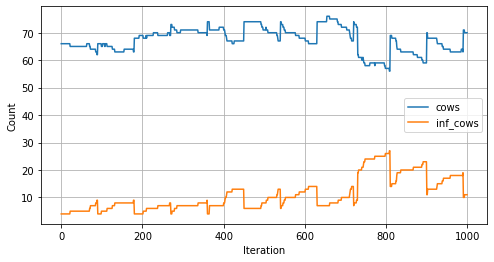

In [146]:
%matplotlib inline
#counts = get_agent_counts(record)
#inf_counts = get_agent_counts(infected_record)
plt.figure(figsize=[8,4])
plt.plot(cc,label='cows')
plt.plot(inf_c,label = "inf_cows")
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Count');